## **Eduardo Carrasco Vidal** <img src="img/logo.png" align="right" style="width: 120px;"/>

**Magister en Inteligencia Artificial, Universidad Adolfo Ibáñez.**

**Profesor:** Juan Bekios.
**Curso:** Aprendizaje Profundo (Deep Learning).

Enlace al repositorio del alumno en [GitHub](https://github.com/educarrascov/MIA_DeepLearning) _@educarrascov_

![Python](https://img.shields.io/badge/python-%2314354C.svg) 

# I. Laboratorio 5.2: Redes LSTM

Construiremos dos ejemplos de redes neuronales recurrentes utilizando LSTM.

## 1. Descargar las base de datos de dos series de tiempo

In [52]:
import requests #Librería para descargar paquetes de internet
#https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
url1 = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv' #URL donde se encuentra el archivo
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
url2 = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv' #URL donde se encuentra el archivo
r1 = requests.get(url1) #comando requests para obtener url
with open("shampoo.csv", "wb") as code: #label del archivo y donde almacenarlo
    code.write(r1.content)
    
r2 = requests.get(url2) #comando requests para obtener url
with open("airline-passenger.csv", "wb") as code: #label del archivo y donde almacenarlo
    code.write(r2.content)

## 2. Cargar librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

## 3. Cargando y revisando los datos de pasajeros de una aerolínea

Leer los datos utilizando Pandas.

In [3]:
training_set = pd.read_csv('airline-passenger.csv')

training_set.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
training_set.describe(include='all')

,Month,Passengers
count,144,144.000000
unique,144,NaN
top,1949-01,NaN
freq,1,NaN
mean,NaN,280.298611
std,NaN,119.966317
min,NaN,104.000000
25%,NaN,180.000000
50%,NaN,265.500000
75%,NaN,360.500000


Graficamos los datos.

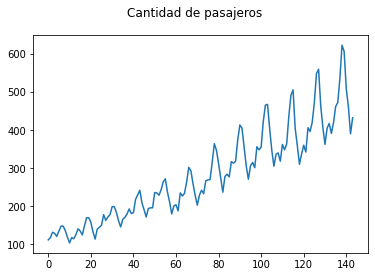

In [5]:
training_set_np = training_set.iloc[:, 1:2].values

# print(training_set_np.shape)

plt.plot(training_set_np)
plt.suptitle('Cantidad de pasajeros')
plt.show()

## 4. Creación de ventana deslizante

Creamos una ventana deslizante, dada una secuencia de tamaño n se desea predecir el siguiente punto.

In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

#escalamos los datos
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set_np)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

## 5. Seleccionamos datos de entrenamiento y validación

Creamos dos particiones una de **entrenamiento** y otra de **validación**. Donde esta última, son los datos después de cierta fecha.

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Conjunto de entrenamiento
train_size = int(len(y) * 0.67)
# Conjunto validacion
val_size = len(y) - train_size

x_train = torch.tensor(x[0:train_size],device=device)
y_train = torch.tensor(y[0:train_size],device=device)
x_val = torch.tensor(x[val_size:],device=device)
y_val = torch.tensor(y[val_size:],device=device)

x = torch.tensor(x,device=device)
y = torch.tensor(y,device=device)

Modelo

In [8]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):    
      ula, (h_n, _) = self.lstm(x)
      h_n = h_n.view(-1, self.hidden_size)
      out = self.fc(h_n)

      return out

In [9]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

#por defecto se crea una lstm con precision de 16bit, en pytorch 1.6.0 hay un bug que no permite el uso de 16bit con lstm
#pasamos la red a doble precision
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device).double()


criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Entrenamiento
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.51424
Epoch: 100, loss: 0.00667
Epoch: 200, loss: 0.00364
Epoch: 300, loss: 0.00349
Epoch: 400, loss: 0.00331
Epoch: 500, loss: 0.00310
Epoch: 600, loss: 0.00284
Epoch: 700, loss: 0.00255
Epoch: 800, loss: 0.00226
Epoch: 900, loss: 0.00205
Epoch: 1000, loss: 0.00196
Epoch: 1100, loss: 0.00189
Epoch: 1200, loss: 0.00183
Epoch: 1300, loss: 0.00178
Epoch: 1400, loss: 0.00176
Epoch: 1500, loss: 0.00175
Epoch: 1600, loss: 0.00175
Epoch: 1700, loss: 0.00175
Epoch: 1800, loss: 0.00174
Epoch: 1900, loss: 0.00174


## 6. Realizamos predicciones y graficamos:

Vemos el resultado sobre el set de datos

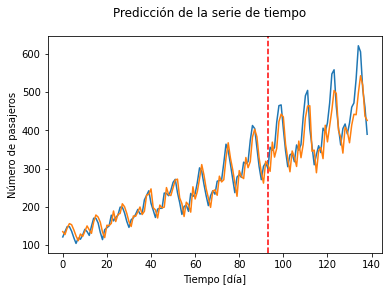

In [10]:
lstm.eval()
train_predict = lstm(x)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = y.cpu().data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
#Dibujamos una linea roja que nos dira cuando comienza el set de validacion
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Predicción de la serie de tiempo')
plt.xlabel('Tiempo [día]')
plt.ylabel('Número de pasajeros')
plt.show()

# II. Laboratorio: Base de datos Shampoo

Este conjunto de datos describe el número mensual de ventas de Shampoo durante un período de 3 años. Las unidades son un conteo de ventas y hay 36 observaciones. El conjunto de datos original se atribuye a Makridakis, Wheelwright y Hyndman (1998).


Nota: Tenga cuidado con las variables training_set, debido a tienen el mismo nombre para diferentes experimentos.

## 1. Cargando y revisando los datos de ventas por mes de shampoo:

In [11]:
training_set = pd.read_csv('shampoo.csv')
training_set.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


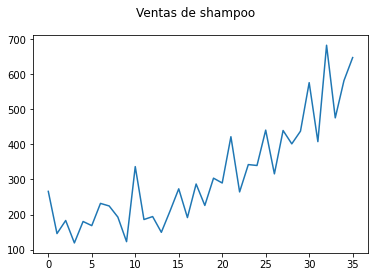

In [12]:
training_set_2 = training_set.iloc[:,1:2].values
plt.plot(training_set_2)
plt.suptitle('Ventas de shampoo')
plt.show()

## 2. Seleccionamos la base de datos de entrenamiento y validación:
Primero creamos una ventana deslizante, dada una secuencia de tamaño n se desea predecir el siguiente punto.

In [16]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)
#escalamos los datos
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set_2)
seq_length = 4

x, y = sliding_windows(training_data, seq_length)

Ahora cargamos la base de datos, seleccionamos un **67% para datos de entrenamiento** y el restante como **datos de validación (33%)**.

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size = int(len(y) * 0.67)
val_size = len(y) - train_size

x_train = torch.tensor(x[0:train_size],device=device)
y_train = torch.tensor(y[0:train_size],device=device)
x_val = torch.tensor(x[val_size:],device=device)
y_val = torch.tensor(y[val_size:],device=device)

x = torch.tensor(x,device=device)
y = torch.tensor(y,device=device)

In [18]:
num_epochs = 10000
learning_rate = 0.1

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

#por defecto se crea una lstm con precision de 16bit, en pytorch 1.6.0 hay un bug que no permite el uso de 16bit con lstm
#pasamos la red a doble precision
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device).double()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, y_train)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1000 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.34005
Epoch: 1000, loss: 0.00060
Epoch: 2000, loss: 0.00000
Epoch: 3000, loss: 0.00001
Epoch: 4000, loss: 0.00001
Epoch: 5000, loss: 0.00001
Epoch: 6000, loss: 0.00000
Epoch: 7000, loss: 0.00000
Epoch: 8000, loss: 0.00000
Epoch: 9000, loss: 0.00000


## 6. Realizamos predicciones y graficamos:
Vemos el resultado sobre el set de datos

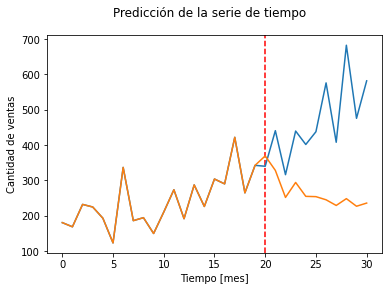

In [19]:
lstm.eval()
train_predict = lstm(x)

data_predict1 = train_predict.cpu().data.numpy()
dataY_plot1 = y.cpu().data.numpy()

data_predict1 = sc.inverse_transform(data_predict1)
dataY_plot1 = sc.inverse_transform(dataY_plot1)
#Dibujamos una linea roja que nos dira cuando comienza el set de validacion
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot1)
plt.plot(data_predict1)
plt.suptitle('Predicción de la serie de tiempo')
plt.xlabel('Tiempo [mes]')
plt.ylabel('Cantidad de ventas')
plt.show()

# Laboratorio 4: Mejorar los resultados de la base de datos de Shampoo

Se pide:

1. Mejorar los resultados de el actual código utilizando redes neuronales recurrentes LSTM.
2. Comparar los resultados del código actual vs el código propuesto por usted o su grupo (utilice métricas para comparar ambos resultados).


## 1. Cargamos la base de datos y generamos la divisón en **entrenamiento** y **validación**

Cargamos la base de datos:

In [20]:
training_set = pd.read_csv('shampoo.csv')
training_set.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [21]:
training_set.describe(include='all')

,Month,Sales
count,36,36.000000
unique,36,NaN
top,1-01,NaN
freq,1,NaN
mean,NaN,312.600000
std,NaN,148.937164
min,NaN,119.300000
25%,NaN,192.450000
50%,NaN,280.150000
75%,NaN,411.100000


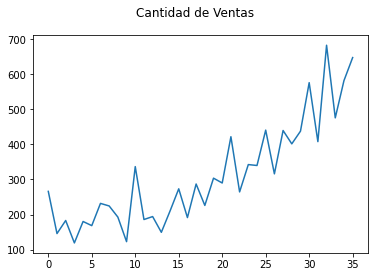

In [22]:
training_set_3 = training_set.iloc[:, 1:2].values
plt.plot(training_set_3)
plt.suptitle('Cantidad de Ventas')
plt.show()

In [23]:
def sliding_windows(data3, seq_length3):
    x = []
    y = []

    for i in range(len(data3)-seq_length-1):
        _x = data3[i:(i+seq_length3)]
        _y = data3[i+seq_length3]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)
#escalamos los datos
sc3 = MinMaxScaler()
training_data3 = sc3.fit_transform(training_set_3)
seq_length3 = 4

x, y = sliding_windows(training_data3, seq_length3)

Cargamos la base de datos, seleccionamos un **67% para datos de entrenamiento** y el restante como **datos de validación (33%)**.

In [24]:
device3 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size3 = int(len(y) * 0.67)
val_size3 = len(y) - train_size3

x_train3 = torch.tensor(x[0:train_size3],device=device)
y_train3 = torch.tensor(y[0:train_size3],device=device)
x_val3 = torch.tensor(x[val_size3:],device=device)
y_val3 = torch.tensor(y[val_size3:],device=device)

x = torch.tensor(x,device=device)
y = torch.tensor(y,device=device)

## 2. Creamos la red Neuronal Long Short-Term Memory (LSTM):

In [34]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):    
      ula, (h_n, _) = self.lstm2(x)
      h_n = h_n.view(-1, self.hidden_size)
      out = self.fc(h_n)

      return out

In [44]:
num_epochs = 16000
learning_rate = 0.1

input_size = 1
hidden_size = 8
num_layers = 1
num_classes = 1

#por defecto se crea una lstm con precision de 16bit, en pytorch 1.6.0 hay un bug que no permite el uso de 16bit con lstm
#pasamos la red a doble precision
lstm2 = LSTM(num_classes, input_size, hidden_size, num_layers).to(device).double()

criterion = torch.nn.MSELoss()    # suma de errores al cuadrado para determinación de error.
optimizer = torch.optim.SGD(lstm2.parameters(), lr=learning_rate,)
# optimizador ADAM.

# Train the model
for epoch in range(num_epochs):
    outputs3 = lstm2(x_train3)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs3, y_train3)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1000 == 0:
      print("Epoch: %d, loss: %6f" % (epoch, loss.item()))

Epoch: 0, loss: 0.030787
Epoch: 1000, loss: 0.015107
Epoch: 2000, loss: 0.013466
Epoch: 3000, loss: 0.012678
Epoch: 4000, loss: 0.012306
Epoch: 5000, loss: 0.012001
Epoch: 6000, loss: 0.011731
Epoch: 7000, loss: 0.011488
Epoch: 8000, loss: 0.011271
Epoch: 9000, loss: 0.011082
Epoch: 10000, loss: 0.010925
Epoch: 11000, loss: 0.010804
Epoch: 12000, loss: 0.010717
Epoch: 13000, loss: 0.010657
Epoch: 14000, loss: 0.010616
Epoch: 15000, loss: 0.010586


## 3. Realizamos predicciones y graficamos:

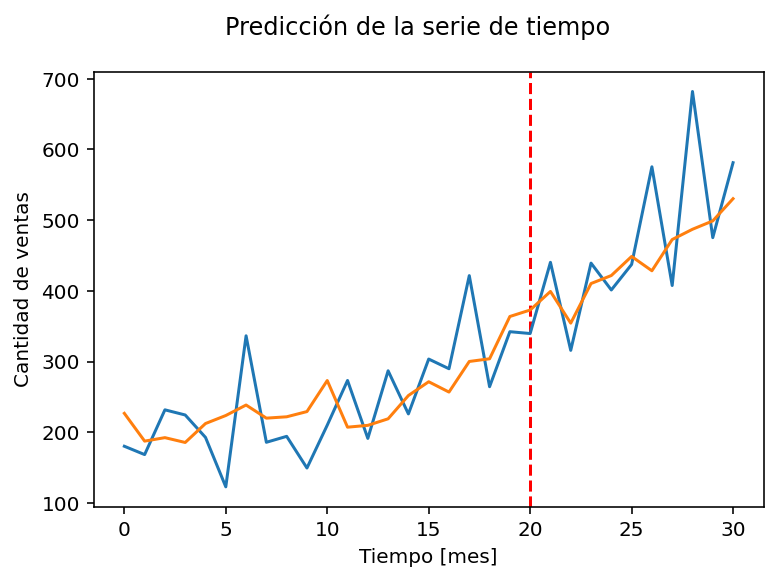

In [45]:
lstm2.eval()
train_predict2 = lstm2(x)

data_predict2 = train_predict2.cpu().data.numpy()
dataY_plot2 = y.cpu().data.numpy()

data_predict2 = sc.inverse_transform(data_predict2)
dataY_plot2 = sc.inverse_transform(dataY_plot2)

#Dibujamos una linea roja que nos dira cuando comienza el set de validacion
plt.axvline(x=train_size3, c='r', linestyle='--')

plt.plot(dataY_plot2)
plt.plot(data_predict2)
plt.suptitle('Predicción de la serie de tiempo')
plt.xlabel('Tiempo [mes]')
plt.ylabel('Cantidad de ventas')
plt.show()

## Resultados

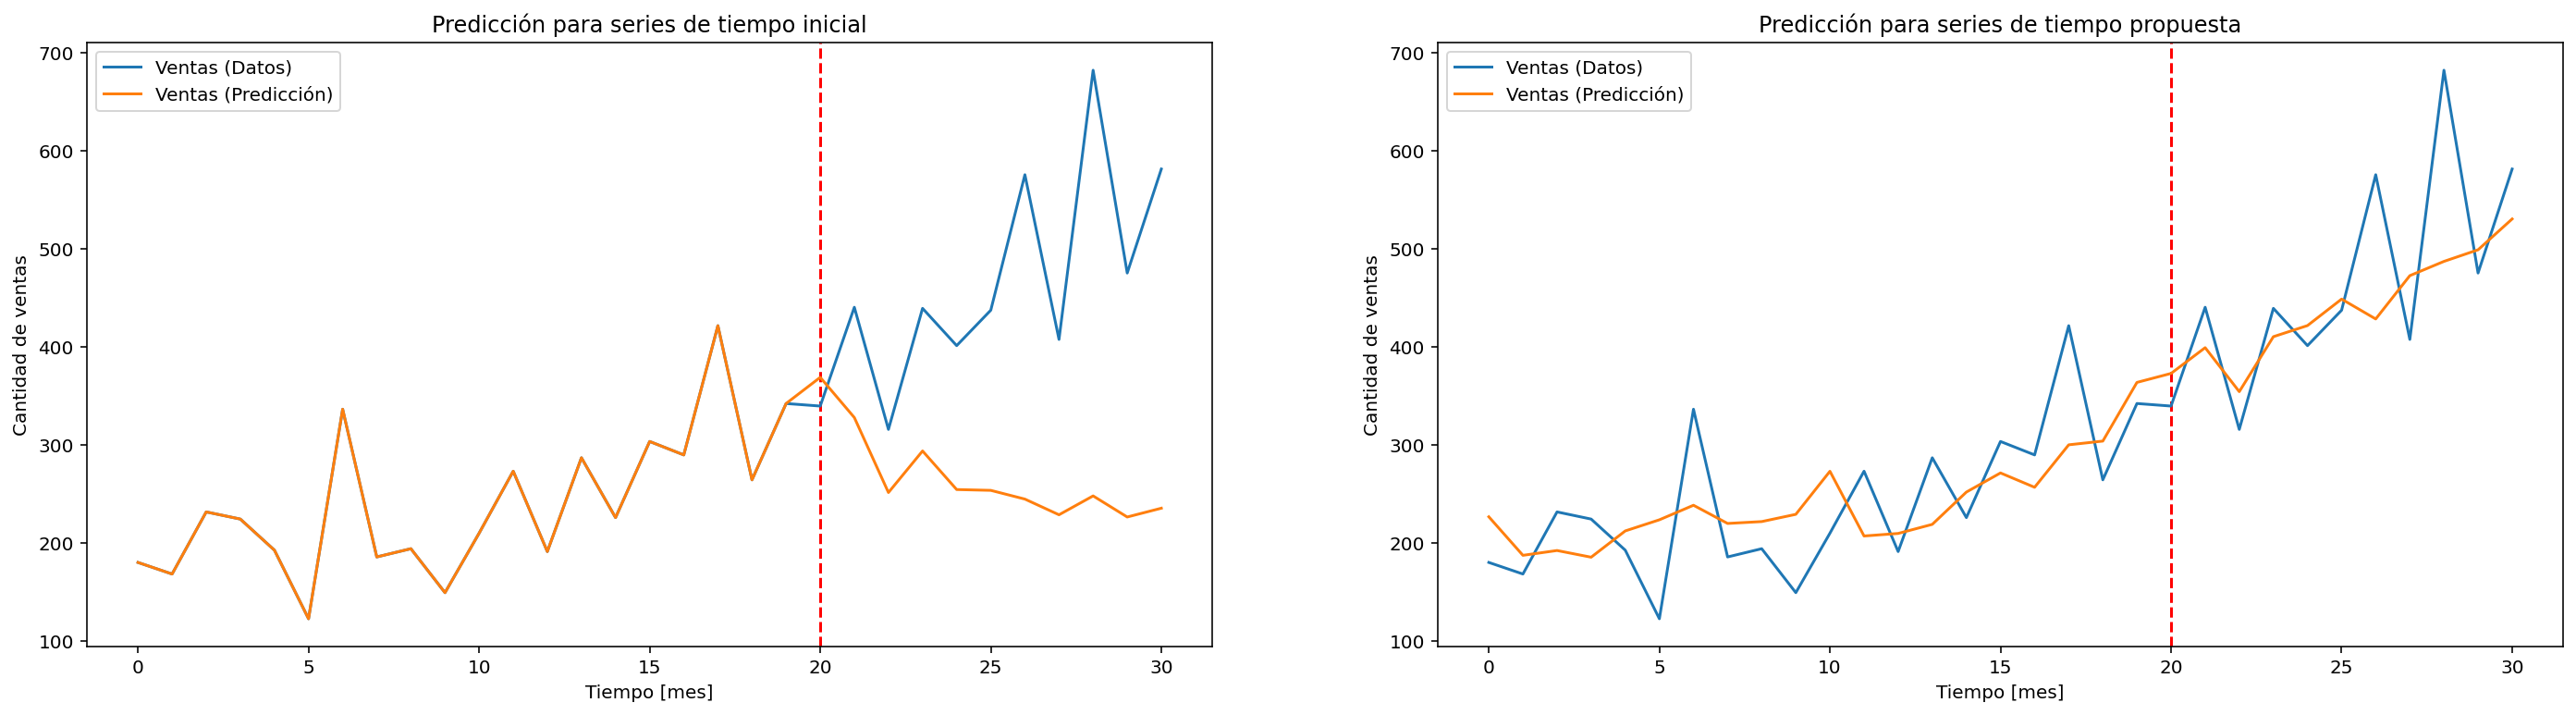

In [46]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot1, label='Ventas (Datos)')
plt.plot(data_predict1, label='Ventas (Predicción)')
plt.title('Predicción para series de tiempo inicial')
plt.xlabel("Tiempo [mes]")
plt.ylabel("Cantidad de ventas")
plt.legend()

plt.subplot(1,2,2)
plt.axvline(x=train_size3, c='r', linestyle='--')
plt.plot(dataY_plot2, label='Ventas (Datos)')
plt.plot(data_predict2, label='Ventas (Predicción)')
plt.title('Predicción para series de tiempo propuesta')
plt.xlabel("Tiempo [mes]")
plt.ylabel("Cantidad de ventas")
plt.legend()

In [60]:
import sklearn
import math
from sklearn import metrics
mse1 = sklearn.metrics.mean_squared_error(dataY_plot1, data_predict1)
rmse1 = math.sqrt(mse1)
print("RMSE de predicción inicial:\n")
print(rmse1)

RMSE de predicción inicial:

139.6861877254255


In [61]:
mse2 = sklearn.metrics.mean_squared_error(dataY_plot2, data_predict2)
rmse2 = math.sqrt(mse2)
print("RMSE de predicción propuesta:\n")
print(rmse2)

RMSE de predicción propuesta:

67.08564292578


## Conclusiones

Cabe destacar que para efectuar la comparación entre la determinada en el ejercicio y la propuesta por el alumno, no se efectuó una modificación en las asignaciones de porcentaje de test y train (objeto mantener las condiciones iniciales).
Después de haber efectuado variadas simulaciones con sólo 36 datos, no importando el `hidden size` indicado, el único valor que sí producía una diferencia es el optimizador, en este caso, utilizando un SGD (Stochastic Gradient Descent).

Dentro del preprocesamiento, se observó que existe una base de datos de sólo 36 observaciones, de las cuales sólo se utiliza el 67% (app 24), para efectos del modelo, lo cual no es suficiente con el optimizador Adam (Adaptative Moment Estimation).

En particular en este problema asociado a una regresión simple y en este caso, se observa en ambos gráficos, que a pesar de que el optimizador SGD no efectúa una predicción eficiente, si logra obtener valores cercanos al real.

Por último, si observamos el `RMSE` (cantidad de error que hay entre dos conjuntos de datos), de cada una de las curvas obtenidas, podemos notar que existe una menor cantidad de error en el segundo que se traduce en un mejor ajuste.